In [103]:
!pip install pulp

# Module 1

Status: Optimal
Objective Value: 289.0
Vehicle 0 travels from 0 to 7
Vehicle 0 travels from 1 to 0
Vehicle 0 travels from 3 to 1
Vehicle 0 travels from 7 to 9
Vehicle 0 travels from 8 to 3
Vehicle 0 travels from 9 to 8
Vehicle 1 travels from 0 to 4
Vehicle 1 travels from 2 to 6
Vehicle 1 travels from 4 to 10
Vehicle 1 travels from 5 to 0
Vehicle 1 travels from 6 to 5
Vehicle 1 travels from 10 to 2


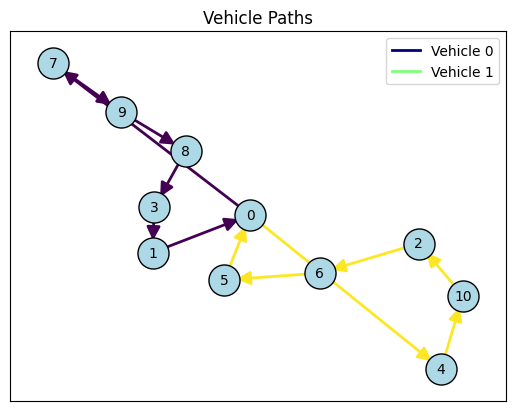

In [ ]:
from pulp import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Problem data
n_customers = 10  # Number of customers
n_vehicles = 5   # Number of vehicles
capacity = 100   # Vehicle capacity
tmax = 150

# Generate random data
np.random.seed(42)
demands = np.random.randint(1, 21, size=n_customers)
service_times = np.random.randint(5, 10, size=n_customers)
distances = np.random.randint(10, 60, size=(n_customers + 1, n_customers + 1))
np.fill_diagonal(distances, 0)  # Set diagonal to 0

# Create the problem
prob = LpProblem("CVRP", LpMinimize)

# Decision variables
x = LpVariable.dicts("route", ((i, j, k) for i in range(n_customers + 1)
                                for j in range(n_customers + 1)
                                for k in range(n_vehicles)), cat='Binary')
y = LpVariable.dicts("visit", ((i, k) for i in range(1, n_customers + 1)
                               for k in range(n_vehicles)), cat='Binary')
t = LpVariable.dicts("time", ((i, k) for i in range(n_customers + 1)
                              for k in range(n_vehicles)), lowBound=0)

# Objective function: minimize total time
prob += lpSum(distances[i][j] * x[i, j, k] for i in range(n_customers + 1)
              for j in range(n_customers + 1) for k in range(n_vehicles)) + \
        lpSum(service_times[i-1] * y[i, k] for i in range(1, n_customers + 1)
              for k in range(n_vehicles))

# Constraints
# Each customer is visited exactly once
for i in range(1, n_customers + 1):
    prob += lpSum(y[i, k] for k in range(n_vehicles)) == 1

# Vehicle capacity constraint
for k in range(n_vehicles):
    prob += lpSum(demands[i-1] * y[i, k] for i in range(1, n_customers + 1)) <= capacity

# Flow conservation
for k in range(n_vehicles):
    for i in range(n_customers + 1):
        prob += lpSum(x[i, j, k] for j in range(n_customers + 1) if i != j) == \
                lpSum(x[j, i, k] for j in range(n_customers + 1) if i != j)

# Link x and y variables
for k in range(n_vehicles):
    for i in range(1, n_customers + 1):
        prob += lpSum(x[i, j, k] for j in range(n_customers + 1) if i != j) == y[i, k]

# Subtour elimination and time tracking
M = tmax  # Big M value
for k in range(n_vehicles):
    prob += t[0, k] == 0  # Start time at depot is 0
    for i in range(n_customers + 1):
        for j in range(1, n_customers + 1):
            if i != j:
                prob += t[j, k] >= t[i, k] + service_times[i-1] + distances[i][j] - \
                        M * (1 - x[i, j, k])

# All vehicles must return to depot before tmax
for k in range(n_vehicles):
    prob += t[0, k] + lpSum(distances[i][0] * x[i, 0, k] for i in range(n_customers + 1)) <= tmax

# Solve the problem
prob.solve()

# Check the status of the solution
print("Status:", LpStatus[prob.status])
objective_value = value(prob.objective)
print(f"Objective Value: {objective_value}")
G = nx.DiGraph()
# Extract and print the optimal solution
for k in range(n_vehicles):
    active_arcs = []
    for i in range(n_customers+1):
        for j in range(n_customers+1):
            if value(x[i, j, k])!=None and value(x[i, j, k])>0.5 :  # Check if the variable exists in the dictionary
                active_arcs.append((i, j))
                G.add_edge(i, j, vehicle=k)
    for (i, j) in active_arcs:
        print(f"Vehicle {k} travels from {i} to {j}")
pos = nx.spring_layout(G, seed=42)  # You can change the layout for better visuals
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', edgecolors='black')
colors = [G[u][v]['vehicle'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20, edge_color=colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
vehicle_colors = list(set(colors))
color_map = {vehicle: plt.cm.jet(i / len(vehicle_colors)) for i, vehicle in enumerate(vehicle_colors)}
legend_elements = [plt.Line2D([0], [0], color=color_map[v], lw=2, label=f'Vehicle {v}') for v in vehicle_colors]
plt.legend(handles=legend_elements, loc='best')
plt.title("Vehicle Paths")
plt.show()

# Module 2

Status: Optimal
Objective Value: 142.0189328483716
Vehicle 0 travels from 0 to 2
Vehicle 0 travels from 2 to 6
Vehicle 0 travels from 4 to 0
Vehicle 0 travels from 6 to 4
Vehicle 2 travels from 0 to 7
Vehicle 2 travels from 1 to 0
Vehicle 2 travels from 3 to 1
Vehicle 2 travels from 5 to 3
Vehicle 2 travels from 7 to 5


<ipython-input-110-7e0dd57ea6c1>:146: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Time')


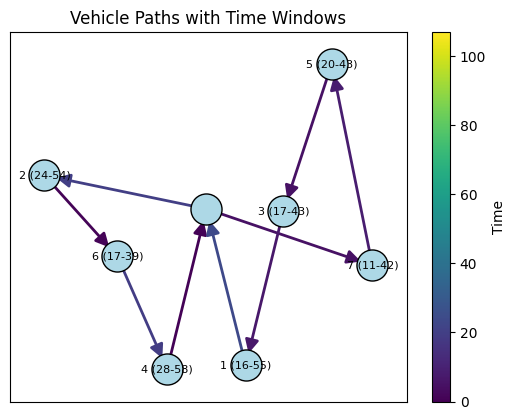

In [110]:
from pulp import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Problem data
n_customers = 7
n_vehicles = 3
capacity = 100
tmax = 300
R = [(4, 6, 5),(1,2,3)]
depot=(0,0)
customer_coords = depot + 20 * np.random.rand(n_customers, 2)
all_coords = np.vstack((depot, customer_coords))
distances = distance_matrix(all_coords, all_coords)

# Generate random time windows (adjust as needed)
np.random.seed(42)
time_windows = {}
for i in range(1, n_customers + 1):
    early = np.random.randint(10, 30)
    late = early + np.random.randint(20, 40)
    time_windows[i] = (early, late)
np.random.seed(42)
demands = np.random.randint(1, 21, size=n_customers)
service_times = np.random.randint(5, 10, size=n_customers)
np.fill_diagonal(distances, 0)



# Create the problem
prob = LpProblem("CVRP", LpMinimize)

# Decision variables
x = LpVariable.dicts("route", ((i, j, k) for i in range(n_customers + 1)
                                for j in range(n_customers + 1)
                                for k in range(n_vehicles)), cat='Binary')
y = LpVariable.dicts("visit", ((i, k) for i in range(1, n_customers + 1)
                               for k in range(n_vehicles)), cat='Binary')
t = LpVariable.dicts("time", ((i, k) for i in range(n_customers + 1)
                              for k in range(n_vehicles)), lowBound=0)

# Objective function: minimize total time
prob += lpSum(distances[i][j] * x[i, j, k] for i in range(n_customers + 1)
              for j in range(n_customers + 1) for k in range(n_vehicles)) + \
        lpSum(service_times[i-1] * y[i, k] for i in range(1, n_customers + 1)
              for k in range(n_vehicles))

# Constraints
# Each customer is visited exactly once
for i in range(1, n_customers + 1):
    prob += lpSum(y[i, k] for k in range(n_vehicles)) == 1

# Vehicle capacity constraint
for k in range(n_vehicles):
    prob += lpSum(demands[i-1] * y[i, k] for i in range(1, n_customers + 1)) <= capacity

# Flow conservation
for k in range(n_vehicles):
    for i in range(n_customers + 1):
        prob += lpSum(x[i, j, k] for j in range(n_customers + 1) if i != j) == \
                lpSum(x[j, i, k] for j in range(n_customers + 1) if i != j)


for k in range(n_vehicles):
  for i in range(1, n_customers + 1):
    for j in range(1, n_customers + 1):
      if i != j:
        # Ensure arrival at j within its time window
        prob += t[j, k] >= t[i, k] + service_times[i-1] + distances[i][j] + \
                time_windows[j][0] - M * (1 - x[i, j, k])
        # Ensure departure from i before j's closing time
        prob += t[i, k] <= t[j, k] - distances[i][j] - service_times[i-1] + \
                M * (1 - x[i, j, k]) + time_windows[j][1]

# Link x and y variables
for k in range(n_vehicles):
    for i in range(1, n_customers + 1):
        prob += lpSum(x[i, j, k] for j in range(n_customers + 1) if i != j) == y[i, k]

# Subtour elimination and time tracking
M = tmax  # Big M value
for k in range(n_vehicles):
    prob += t[0, k] == 0  # Start time at depot is 0
    for i in range(n_customers + 1):
        for j in range(1, n_customers + 1):
            if i != j:
                prob += t[j, k] >= t[i, k] + service_times[i-1] + distances[i][j] - \
                        M * (1 - x[i, j, k])

# All vehicles must return to depot before tmax
for k in range(n_vehicles):
    prob += t[0, k] + lpSum(distances[i][0] * x[i, 0, k] for i in range(n_customers + 1)) <= tmax

#Make sure to respect the rules (forbiden nodes)
for i, j, l in R:
    for k in range(n_vehicles):
        prob += y[l, k] <= 2 - y[i, k] - y[j,k]

# Solve the problem
prob.solve()

# Check the status of the solution
print("Status:", LpStatus[prob.status])
objective_value = value(prob.objective)
print(f"Objective Value: {objective_value}")
G = nx.DiGraph()

for k in range(n_vehicles):
    active_arcs = []
    for i in range(n_customers+1):
        for j in range(n_customers+1):
            if value(x[i, j, k])!=None and value(x[i, j, k])>0.5 :
                active_arcs.append((i, j))
                G.add_edge(i, j, vehicle=k)
    for (i, j) in active_arcs:
        print(f"Vehicle {k} travels from {i} to {j}")
pos = nx.spring_layout(G, seed=42)
min_time = float('inf')
max_time = float('-inf')

for k in range(n_vehicles):
    for i in range(n_customers + 1):
        min_time = min(min_time, t[i, k].varValue)
        max_time = max(max_time, t[i, k].varValue)

node_labels = {i: f"{i} ({time_windows[i][0]}-{time_windows[i][1]})" for i in range(1, n_customers + 1)}
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif')

for u, v in G.edges():
    travel_time = distances[u][v]
    G.edges[u, v]['time'] = travel_time


edge_colors = []
for u, v, data in G.edges(data=True):
    edge_color = plt.cm.viridis((data['time'] - min_time) / (max_time - min_time))
    edge_colors.append(edge_color)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20, edge_color=edge_colors, width=2)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min_time, vmax=max_time))
plt.colorbar(sm, label='Time')

plt.title("Vehicle Paths with Time Windows")
plt.show()

# Module 3

In [106]:
from scipy.spatial import distance_matrix

# Problem data
n_customers = 7
n_vehicles = 3
capacity = 100
tmax = 300
n_lockers = 5
np.random.seed(42)
time_windows = {}
for i in range(1, n_customers + 1):
    early = np.random.randint(10, 30)
    late = early + np.random.randint(20, 40)
    time_windows[i] = (early, late)

demands = np.random.randint(1, 21, size=n_customers)
service_times = np.random.randint(5, 10, size=n_customers)
distances = np.random.randint(10, 60, size=(n_customers + n_lockers + 1, n_customers + n_lockers + 1))
np.fill_diagonal(distances, 0)
depot = (0, 0)
np.random.seed(42)
customer_coords = depot + 20 * np.random.rand(n_customers, 2)
all_coords = np.vstack((depot, customer_coords))
distances = distance_matrix(all_coords, all_coords)
locker_coords = 20 * np.random.rand(n_lockers, 2)
customer_locker_distances = distance_matrix(customer_coords, locker_coords)
demands = np.random.randint(1, 21, size=n_customers)
time_windows = [(np.random.randint(8, 10), np.random.randint(14, 18)) for _ in range(n_customers)]
customer_ids = [f'C{i+1}' for i in range(n_customers)]
locker_ids = [f'L{i+1}' for i in range(n_lockers)]

distance_threshold = 10

# Function to assign customers to parcel lockers based on proximity
def assign_customers_to_lockers(D, d, customer_ids, locker_ids, demands, time_windows):
    C, P = D.shape
    new_customers = []
    customer_locker_mapping = {locker: [] for locker in locker_ids}
    new_demands = []
    new_time_windows = []

    for i in range(C):
        closest_locker_idx = np.argmin(D[i, :])
        if D[i, closest_locker_idx] <= d:
            closest_locker = locker_ids[closest_locker_idx]
            customer_locker_mapping[closest_locker].append(customer_ids[i])
        else:
            new_customers.append(customer_ids[i])
            new_demands.append(demands[i])
            new_time_windows.append(time_windows[i])

    for locker, assigned_customers in customer_locker_mapping.items():
        if assigned_customers:
            new_customers.append(locker)
            total_demand = sum(demands[customer_ids.index(cust)] for cust in assigned_customers)
            new_demands.append(total_demand)
            new_time_windows.append((0, tmax))

    return new_customers, np.array(new_demands), np.array(new_time_windows), customer_locker_mapping

new_customers, new_demands, new_time_windows, customer_locker_mapping = assign_customers_to_lockers(
    customer_locker_distances,
    distance_threshold,
    customer_ids,
    locker_ids,
    demands,
    time_windows
)

# Output the results
print("New Customers Set:", new_customers)
print("Updated Demands:", new_demands)
print("Updated Time Windows:", new_time_windows)
print("Customer-Locker Mapping:", customer_locker_mapping)

# Collect coordinates for the new customer set (customers and lockers)
new_customer_coords = []
for cust in new_customers:
    if cust in customer_ids:
        new_customer_coords.append(customer_coords[customer_ids.index(cust)])
    elif cust in locker_ids:
        new_customer_coords.append(locker_coords[locker_ids.index(cust)])

new_customer_coords = np.array(new_customer_coords)
new_distances = distance_matrix(np.vstack((depot, new_customer_coords)), np.vstack((depot, new_customer_coords)))

print("New Distance Matrix (Depot + New Customers Set):\n", new_distances)


New Customers Set: ['C6', 'L1', 'L2', 'L3', 'L4']
Updated Demands: [ 5 12 38 19 19]
Updated Time Windows: [[  9  14]
 [  0 300]
 [  0 300]
 [  0 300]
 [  0 300]]
Customer-Locker Mapping: {'L1': ['C3'], 'L2': ['C1', 'C4', 'C5'], 'L3': ['C2'], 'L4': ['C7'], 'L5': []}
New Distance Matrix (Depot + New Customers Set):
 [[ 0.         19.40256522  5.1651731  12.13149051 10.41903856 12.55105576]
 [19.40256522  0.         16.05726183 10.55695574 15.87230279 20.38812439]
 [ 5.1651731  16.05726183  0.          7.25278219  5.44742842  8.64527995]
 [12.13149051 10.55695574  7.25278219  0.          5.32326948  9.86005196]
 [10.41903856 15.87230279  5.44742842  5.32326948  0.          4.70703469]
 [12.55105576 20.38812439  8.64527995  9.86005196  4.70703469  0.        ]]


Status: Optimal
Objective Value: 95.87122709094464
Vehicle 0 travels from 0 to 5
Vehicle 0 travels from 1 to 0
Vehicle 0 travels from 3 to 1
Vehicle 0 travels from 4 to 3
Vehicle 0 travels from 5 to 4
Vehicle 2 travels from 0 to 2
Vehicle 2 travels from 2 to 0


<ipython-input-114-f1de7f5498e4>:125: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Time')


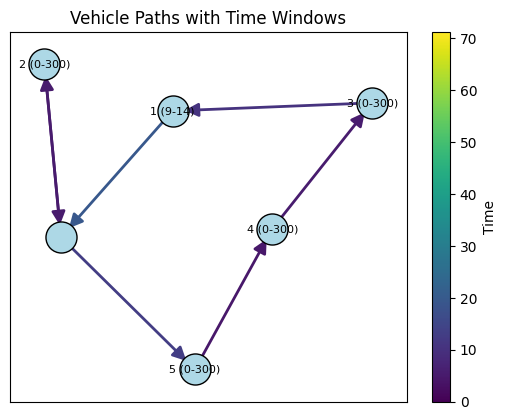

In [114]:
tmax = 300
R = [(1,2,5)]
n_customers=len(new_customers)
time_windows = new_time_windows
time_windows = {i + 1: tuple(window) for i, window in enumerate(time_windows)}
demands = new_demands
service_times = np.random.randint(5, 10, size=n_customers)
distances = new_distances
np.fill_diagonal(distances, 0)

# Create the problem
prob = LpProblem("CVRP", LpMinimize)

# Decision variables
x = LpVariable.dicts("route", ((i, j, k) for i in range(n_customers + 1)
                                for j in range(n_customers + 1)
                                for k in range(n_vehicles)), cat='Binary')
y = LpVariable.dicts("visit", ((i, k) for i in range(1, n_customers + 1)
                               for k in range(n_vehicles)), cat='Binary')
t = LpVariable.dicts("time", ((i, k) for i in range(n_customers + 1)
                              for k in range(n_vehicles)), lowBound=0)

# Objective function: minimize total time
prob += lpSum(distances[i][j] * x[i, j, k] for i in range(n_customers + 1)
              for j in range(n_customers + 1) for k in range(n_vehicles)) + \
        lpSum(service_times[i-1] * y[i, k] for i in range(1, n_customers + 1)
              for k in range(n_vehicles))

# Constraints
# Each customer is visited exactly once
for i in range(1, n_customers + 1):
    prob += lpSum(y[i, k] for k in range(n_vehicles)) == 1

# Vehicle capacity constraint
for k in range(n_vehicles):
    prob += lpSum(demands[i-1] * y[i, k] for i in range(1, n_customers + 1)) <= capacity

# Flow conservation
for k in range(n_vehicles):
    for i in range(n_customers + 1):
        prob += lpSum(x[i, j, k] for j in range(n_customers + 1) if i != j) == \
                lpSum(x[j, i, k] for j in range(n_customers + 1) if i != j)


for k in range(n_vehicles):
  for i in range(1, n_customers + 1):
    for j in range(1, n_customers + 1):
      if i != j:
        # Ensure arrival at j within its time window
        prob += t[j, k] >= t[i, k] + service_times[i-1] + distances[i][j] + \
                time_windows[j][0] - M * (1 - x[i, j, k])
        # Ensure departure from i before j's closing time
        prob += t[i, k] <= t[j, k] - distances[i][j] - service_times[i-1] + \
                M * (1 - x[i, j, k]) + time_windows[j][1]

# Link x and y variables
for k in range(n_vehicles):
    for i in range(1, n_customers + 1):
        prob += lpSum(x[i, j, k] for j in range(n_customers + 1) if i != j) == y[i, k]

# Subtour elimination and time tracking
M = tmax  # Big M value
for k in range(n_vehicles):
    prob += t[0, k] == 0  # Start time at depot is 0
    for i in range(n_customers + 1):
        for j in range(1, n_customers + 1):
            if i != j:
                prob += t[j, k] >= t[i, k] + service_times[i-1] + distances[i][j] - \
                        M * (1 - x[i, j, k])

# All vehicles must return to depot before tmax
for k in range(n_vehicles):
    prob += t[0, k] + lpSum(distances[i][0] * x[i, 0, k] for i in range(n_customers + 1)) <= tmax

#Make sure to respect the rules (forbiden nodes)

for i, j, l in R:
    for k in range(n_vehicles):
        prob += y[l, k] <= 2 - y[i, k] - y[j,k]


# Solve the problem
prob.solve()

# Check the status of the solution
print("Status:", LpStatus[prob.status])
objective_value = value(prob.objective)
print(f"Objective Value: {objective_value}")
G = nx.DiGraph()

for k in range(n_vehicles):
    active_arcs = []
    for i in range(n_customers+1):
        for j in range(n_customers+1):
            if value(x[i, j, k])!=None and value(x[i, j, k])>0.5 :
                active_arcs.append((i, j))
                G.add_edge(i, j, vehicle=k)
    for (i, j) in active_arcs:
        print(f"Vehicle {k} travels from {i} to {j}")
pos = nx.spring_layout(G, seed=42)
min_time = float('inf')
max_time = float('-inf')

for k in range(n_vehicles):
    for i in range(n_customers + 1):
        min_time = min(min_time, t[i, k].varValue)
        max_time = max(max_time, t[i, k].varValue)

node_labels = {i: f"{i} ({time_windows[i][0]}-{time_windows[i][1]})" for i in range(1, n_customers + 1)}
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif')

for u, v in G.edges():
    travel_time = distances[u][v]
    G.edges[u, v]['time'] = travel_time


edge_colors = []
for u, v, data in G.edges(data=True):
    edge_color = plt.cm.viridis((data['time'] - min_time) / (max_time - min_time))
    edge_colors.append(edge_color)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20, edge_color=edge_colors, width=2)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min_time, vmax=max_time))
plt.colorbar(sm, label='Time')

plt.title("Vehicle Paths with Time Windows")
plt.show()

# Module 4

Status: Optimal
Objective Value: 15.5833024
Vehicle 0 travels from 0 to 3
Vehicle 0 travels from 3 to 4
Vehicle 0 travels from 4 to 0
Vehicle 1 travels from 0 to 1
Vehicle 1 travels from 1 to 0
Vehicle 2 travels from 0 to 5
Vehicle 2 travels from 2 to 0
Vehicle 2 travels from 5 to 2


<ipython-input-115-0a01a592bc5d>:69: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Time')


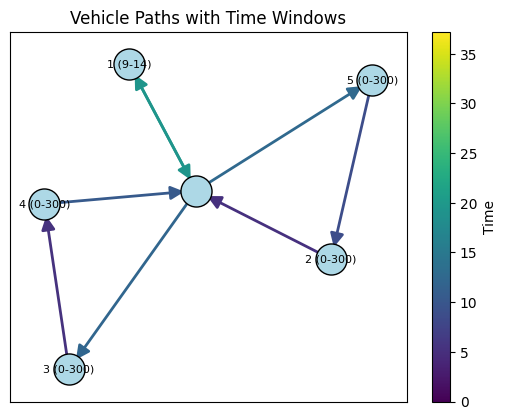

In [115]:
optimal_first_obj_value = pulp.value(prob.objective)
allowable_degradation = 0.05 * optimal_first_obj_value

driver_return_times = [
    pulp.lpSum(distances[i, j] * x[i, j, k] for i in range(n_customers+1) for j in range(n_customers+1) if i != j)
    for k in range(n_vehicles)
]

avg_return_time = pulp.LpVariable('avg_return_time', lowBound=0, cat='Continuous')
mad = pulp.LpVariable.dicts('mad', (range(n_vehicles)), lowBound=0, cat='Continuous')

# Add constraints for MAD
for k in range(n_vehicles):
    prob += mad[k] >= driver_return_times[k] - avg_return_time
    prob += mad[k] >= avg_return_time - driver_return_times[k]

prob += avg_return_time == pulp.lpSum(driver_return_times) / n_vehicles

# Constraint: Allowable degradation in the primary objective
prob += pulp.lpSum(distances[i, j] * x[i, j, k] for k in range(n_vehicles) for i in range(n_customers+1) for j in range(n_customers+1) if i != j) <= optimal_first_obj_value + allowable_degradation

# Define a new objective to minimize the sum of MAD
secondary_obj = pulp.lpSum(mad[k] for k in range(n_vehicles))

# Solve the model with primary objective first and then the secondary objective
prob.setObjective(secondary_obj)
prob.solve()


print("Status:", LpStatus[prob.status])
objective_value = value(prob.objective)
print(f"Objective Value: {objective_value}")
G = nx.DiGraph()

for k in range(n_vehicles):
    active_arcs = []
    for i in range(n_customers+1):
        for j in range(n_customers+1):
            if value(x[i, j, k])!=None and value(x[i, j, k])>0.5 :
                active_arcs.append((i, j))
                G.add_edge(i, j, vehicle=k)
    for (i, j) in active_arcs:
        print(f"Vehicle {k} travels from {i} to {j}")
pos = nx.spring_layout(G, seed=42)
min_time = float('inf')
max_time = float('-inf')

for k in range(n_vehicles):
    for i in range(n_customers + 1):
        min_time = min(min_time, t[i, k].varValue)
        max_time = max(max_time, t[i, k].varValue)

node_labels = {i: f"{i} ({time_windows[i][0]}-{time_windows[i][1]})" for i in range(1, n_customers + 1)}
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif')

for u, v in G.edges():
    travel_time = distances[u][v]
    G.edges[u, v]['time'] = travel_time


edge_colors = []
for u, v, data in G.edges(data=True):
    edge_color = plt.cm.viridis((data['time'] - min_time) / (max_time - min_time))
    edge_colors.append(edge_color)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20, edge_color=edge_colors, width=2)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min_time, vmax=max_time))
plt.colorbar(sm, label='Time')

plt.title("Vehicle Paths with Time Windows")
plt.show()